In [ ]:
# Experimental Treemap for V&A API v2

In [177]:
# Get aggregation data from new API
import sys 
sys.path

import pandas as pd
import requests as req
import json
from IPython.display import display

def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

stats = req.get("http://20.49.162.179/api/v2/objectclusters/search")

stats_json = stats.json()

persons = stats_json["aggregations"]["object_types"]["buckets"]

person_json = [{"id": index+1, "name": x["key"], "parent": '0', "value": x["doc_count"]} for index, x in enumerate(persons)]
#person_json = [{"id": index+100, "name": x["key"], "parent": index, "value": x["doc_count"]} for index, x in enumerate(persons)]
#person_json = [{"id": index+201, "name": x["key"], "parent": 101+index, "value": x["doc_count"]} for index, x in enumerate(persons)]
person_json.insert(0, {"id": 0, "value": 0, "name": "Object Type"})


#print(json.dumps(person_json))
#print(person_json)
treemap_json = {"children":
                 [{"name": x["key"], "value": x["doc_count"]} for x in persons],
                "name": "Objects"
               }
#print(treemap_json)

#df = pd.read_json(json.dumps(persons))

# We just want the aggregrations

#df.info()



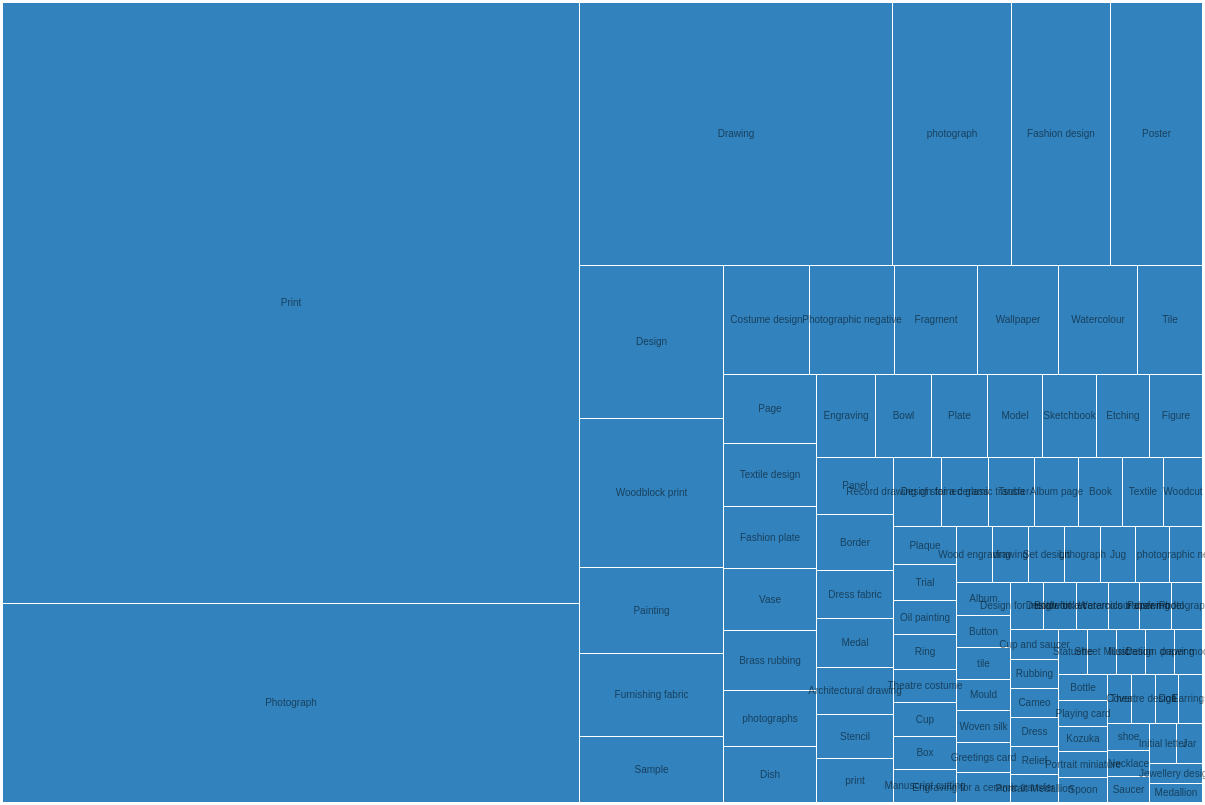

In [181]:
Vega({
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of treemap layout for hierarchical data.",
  "width": 1200,
  "height": 800,
  "padding": 2.5,
  "autosize": "none",

  "signals": [
    {
      "name": "layout", "value": "squarify",
      "bind": {
        "input": "select",
        "options": [
          "squarify",
          "binary",
          "slicedice"
        ]
      }
    },
    {
      "name": "aspectRatio", "value": 1.6,
      "bind": {"input": "range", "min": 1, "max": 5, "step": 0.1}
    }
  ],

  "data": [
    {
      "name": "tree",
      "values": person_json,
      "transform": [
        {
          "type": "stratify",
          "key": "id",
          "parentKey": "parent"
        },
        {
          "type": "treemap",
          "field": "value",
          "sort": {"field": "value", "order": "descending"},
          "round": True,
          "method": {"signal": "layout"},
          "ratio": {"signal": "aspectRatio"},
          "size": [{"signal": "width"}, {"signal": "height"}]
        }
      ]
    },
    {
      "name": "nodes",
      "source": "tree",
      "transform": [{ "type": "filter", "expr": "datum.children" }]
    },
    {
      "name": "leaves",
      "source": "tree",
      "transform": [{ "type": "filter", "expr": "datum.parent == 0" }]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "nodes", "field": "name"},
      "range": [
        "#3182bd", "#6baed6", "#9ecae1", "#c6dbef", "#e6550d",
        "#fd8d3c", "#fdae6b", "#fdd0a2", "#31a354", "#74c476",
        "#a1d99b", "#c7e9c0", "#756bb1", "#9e9ac8", "#bcbddc",
        "#dadaeb", "#636363", "#969696", "#bdbdbd", "#d9d9d9"
      ]
    },
    {
      "name": "size",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [256, 10, 20, 14]
    },
    {
      "name": "opacity",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0.15, 0.5, 0.8, 1.0]
    }
  ],

  "marks": [
    {
      "type": "rect",
      "from": {"data": "nodes"},
      "interactive": False,
      "encode": {
        "enter": {
          "fill": {"scale": "color", "field": "name"}
        },
        "update": {
          "x": {"field": "x0"},
          "y": {"field": "y0"},
          "x2": {"field": "x1"},
          "y2": {"field": "y1"}
        }
      }
    },
    {
      "type": "rect",
      "from": {"data": "leaves"},
      "encode": {
        "enter": {
          "stroke": {"value": "#fff"}
        },
        "update": {
          "x": {"field": "x0"},
          "y": {"field": "y0"},
          "x2": {"field": "x1"},
          "y2": {"field": "y1"},
          "fill": {"value": "transparent"}
        },
        "hover": {
          "fill": {"value": "red"}
        }
      }
    },
    {
      "type": "text",
      "from": {"data": "leaves"},
      "interactive": False,
      "encode": {
        "enter": {
          "font": {"value": "Helvetica Neue, Arial"},
          "align": {"value": "center"},
          "baseline": {"value": "middle"},
          "fill": {"value": "#000"},
          "text": {"field": "name"},
          "fontSize": {"scale": "size", "field": "depth"},
          "fillOpacity": {"scale": "opacity", "field": "depth"}
        },
        "update": {
          "x": {"signal": "0.5 * (datum.x0 + datum.x1)"},
          "y": {"signal": "0.5 * (datum.y0 + datum.y1)"}
        }
      }
    }
  ]
}
)